# **Etapa 2 - Entrenamiento y comparación de Modelos de Clasificación**
-----

mps
                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      1.00      1.00        10
American Hairless       1.00      0.70      0.82        10
 American Spaniel       1.00      0.50      0.67        10
          Basenji       0.67      1.00      0.80        10
           Basset       0.83      1.00      0.91        10
           Beagle       1.00      0.90      0.95        10
   Bearded Collie       1.00      0.90      0.95        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       1.00      0.90      0.95        10
         Bluetick       1.00      1.00      1.00        10
    Border Collie       1.00      1.00      1.00        10
           Borzoi       1.00      1.00      1.00   

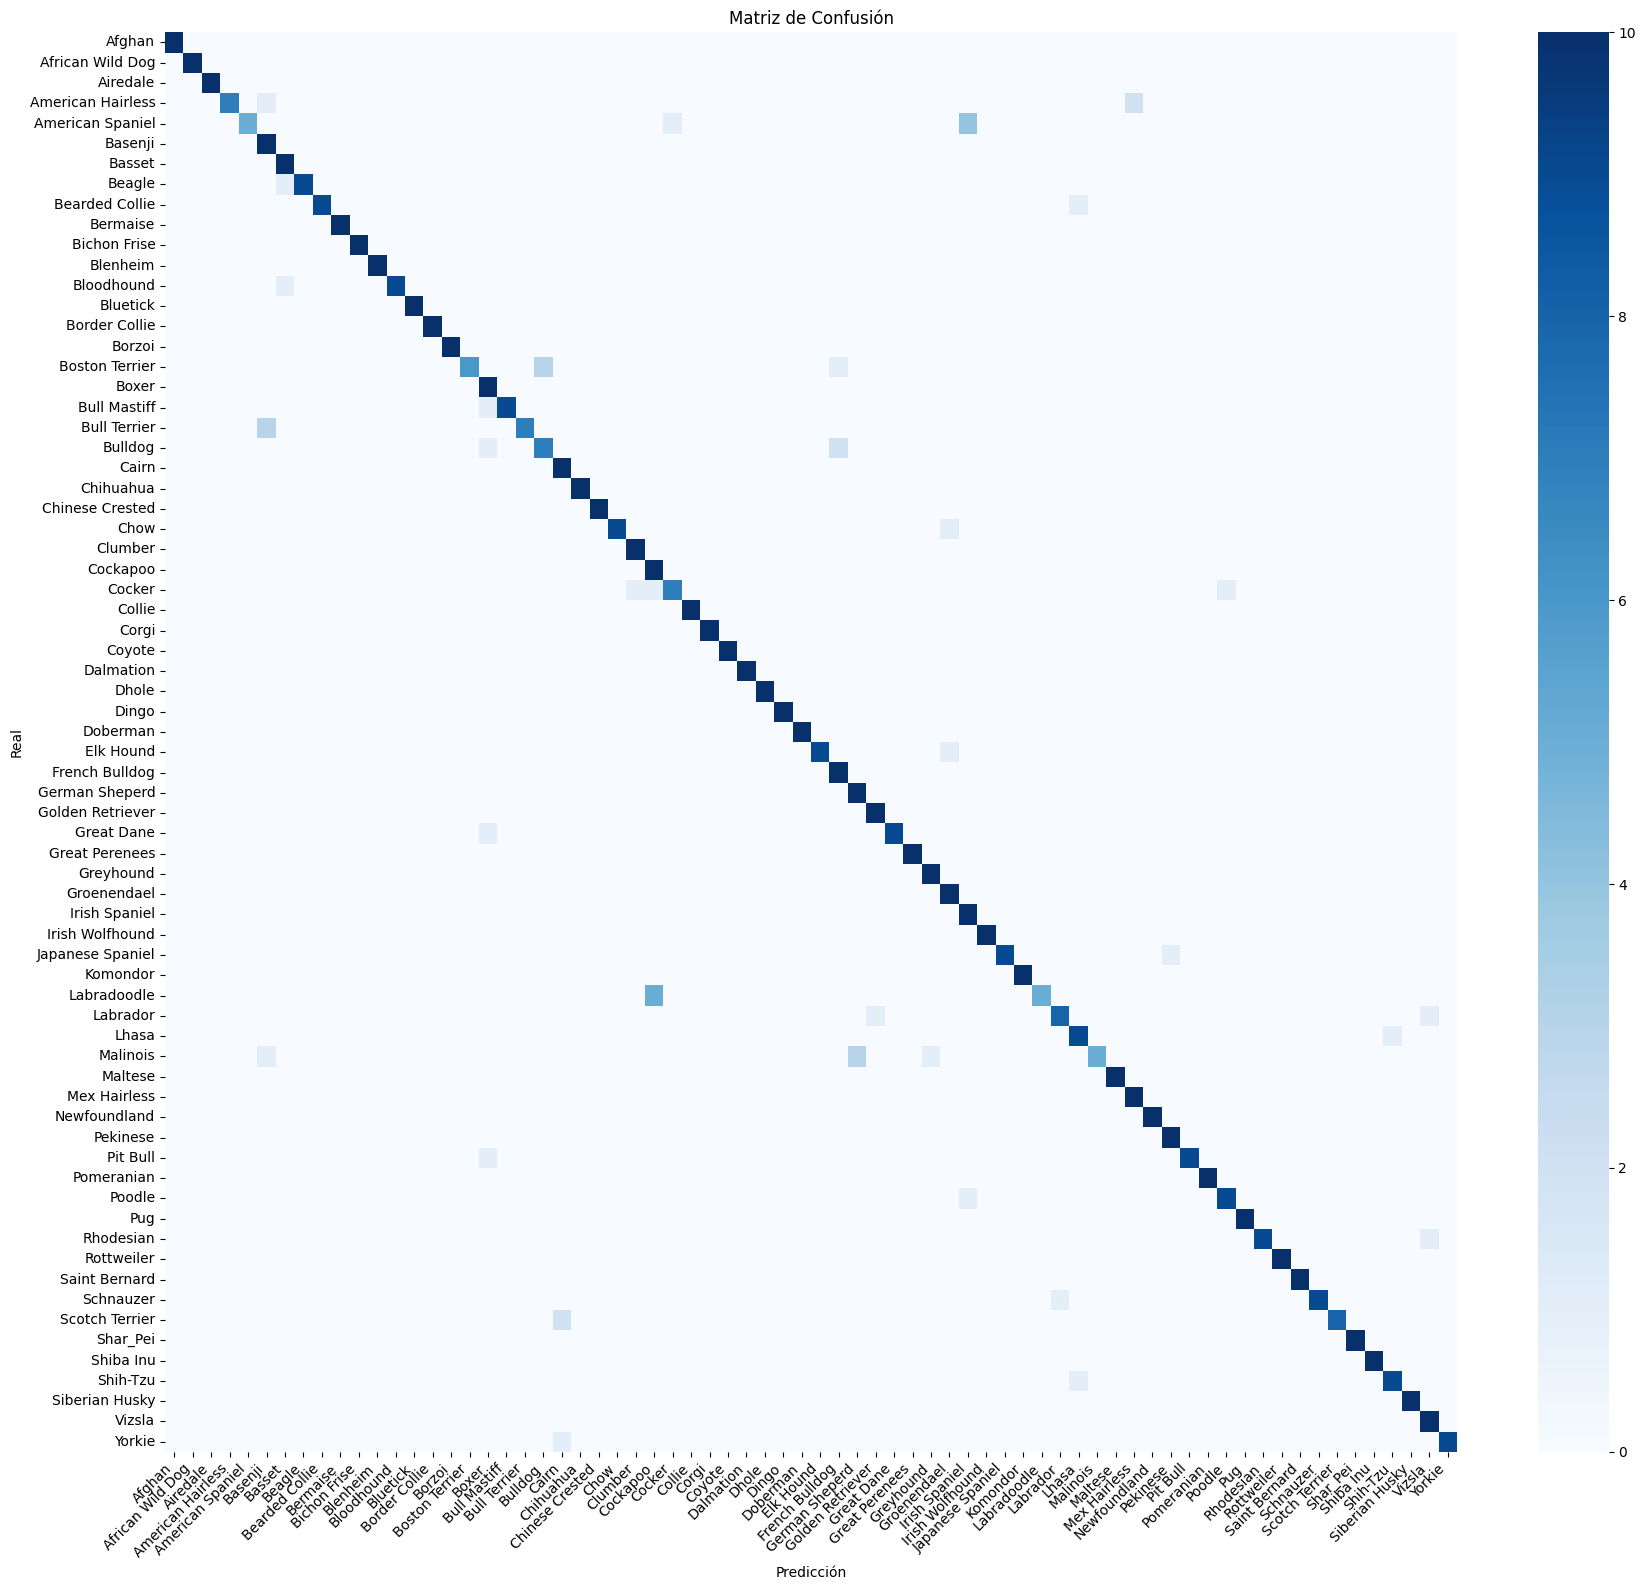

In [3]:
import torch
import torch.nn as nn
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = datasets.ImageFolder('../dog-images/train', transform=transform)
val_dataset = datasets.ImageFolder('../dog-images/valid', transform=transform)
test_dataset = datasets.ImageFolder('../dog-images/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Modelo ResNet18 preentrenado
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  

# Fine-tuning
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Entrenamiento simple (solo 1 época para ejemplo)
for epoch in range(1):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 16))
sns.heatmap(
    cm, 
    annot=False, 
    fmt='d', 
    cmap='Blues',
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes
)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### ResNet 18
-----

**Principales hallazgos:**

- La mayoría de las razas presentan valores de *precisión*, *recall* y *f1-score* superiores a **0.90**, lo que indica que el modelo identifica correctamente la mayoría de las clases.
- Sin embargo, algunas razas como **"Boston Terrier"**, **"Bulldog"**, **"Malinois"** y **"Dingo"** presentan valores más bajos, lo que sugiere que el modelo tiene dificultades para distinguirlas, posiblemente por *similitud visual* (Como sucede con el Cockapoo y el Labradoodle) o *menor cantidad de datos* (Siendo este el caso del Boston Terrier).
- El promedio *macro* y *ponderado* de las métricas también es alto (**alrededor de 0.92-0.93**), confirmando un buen rendimiento general y un balance adecuado entre las clases.

**Sintesis:**  
El modelo muestra un rendimiento robusto en la mayoría de las clases, aunque existen algunas oportunidades de mejora en razas específicas.

                   precision    recall  f1-score   support

           Afghan       0.36      0.40      0.38        10
 African Wild Dog       0.14      0.20      0.17        10
         Airedale       0.12      0.10      0.11        10
American Hairless       0.12      0.10      0.11        10
 American Spaniel       0.22      0.20      0.21        10
          Basenji       0.33      0.40      0.36        10
           Basset       0.29      0.40      0.33        10
           Beagle       0.24      0.40      0.30        10
   Bearded Collie       0.50      0.10      0.17        10
         Bermaise       0.25      0.20      0.22        10
     Bichon Frise       0.71      0.50      0.59        10
         Blenheim       0.33      0.30      0.32        10
       Bloodhound       0.08      0.10      0.09        10
         Bluetick       0.38      0.30      0.33        10
    Border Collie       0.46      0.60      0.52        10
           Borzoi       0.40      0.20      0.27       

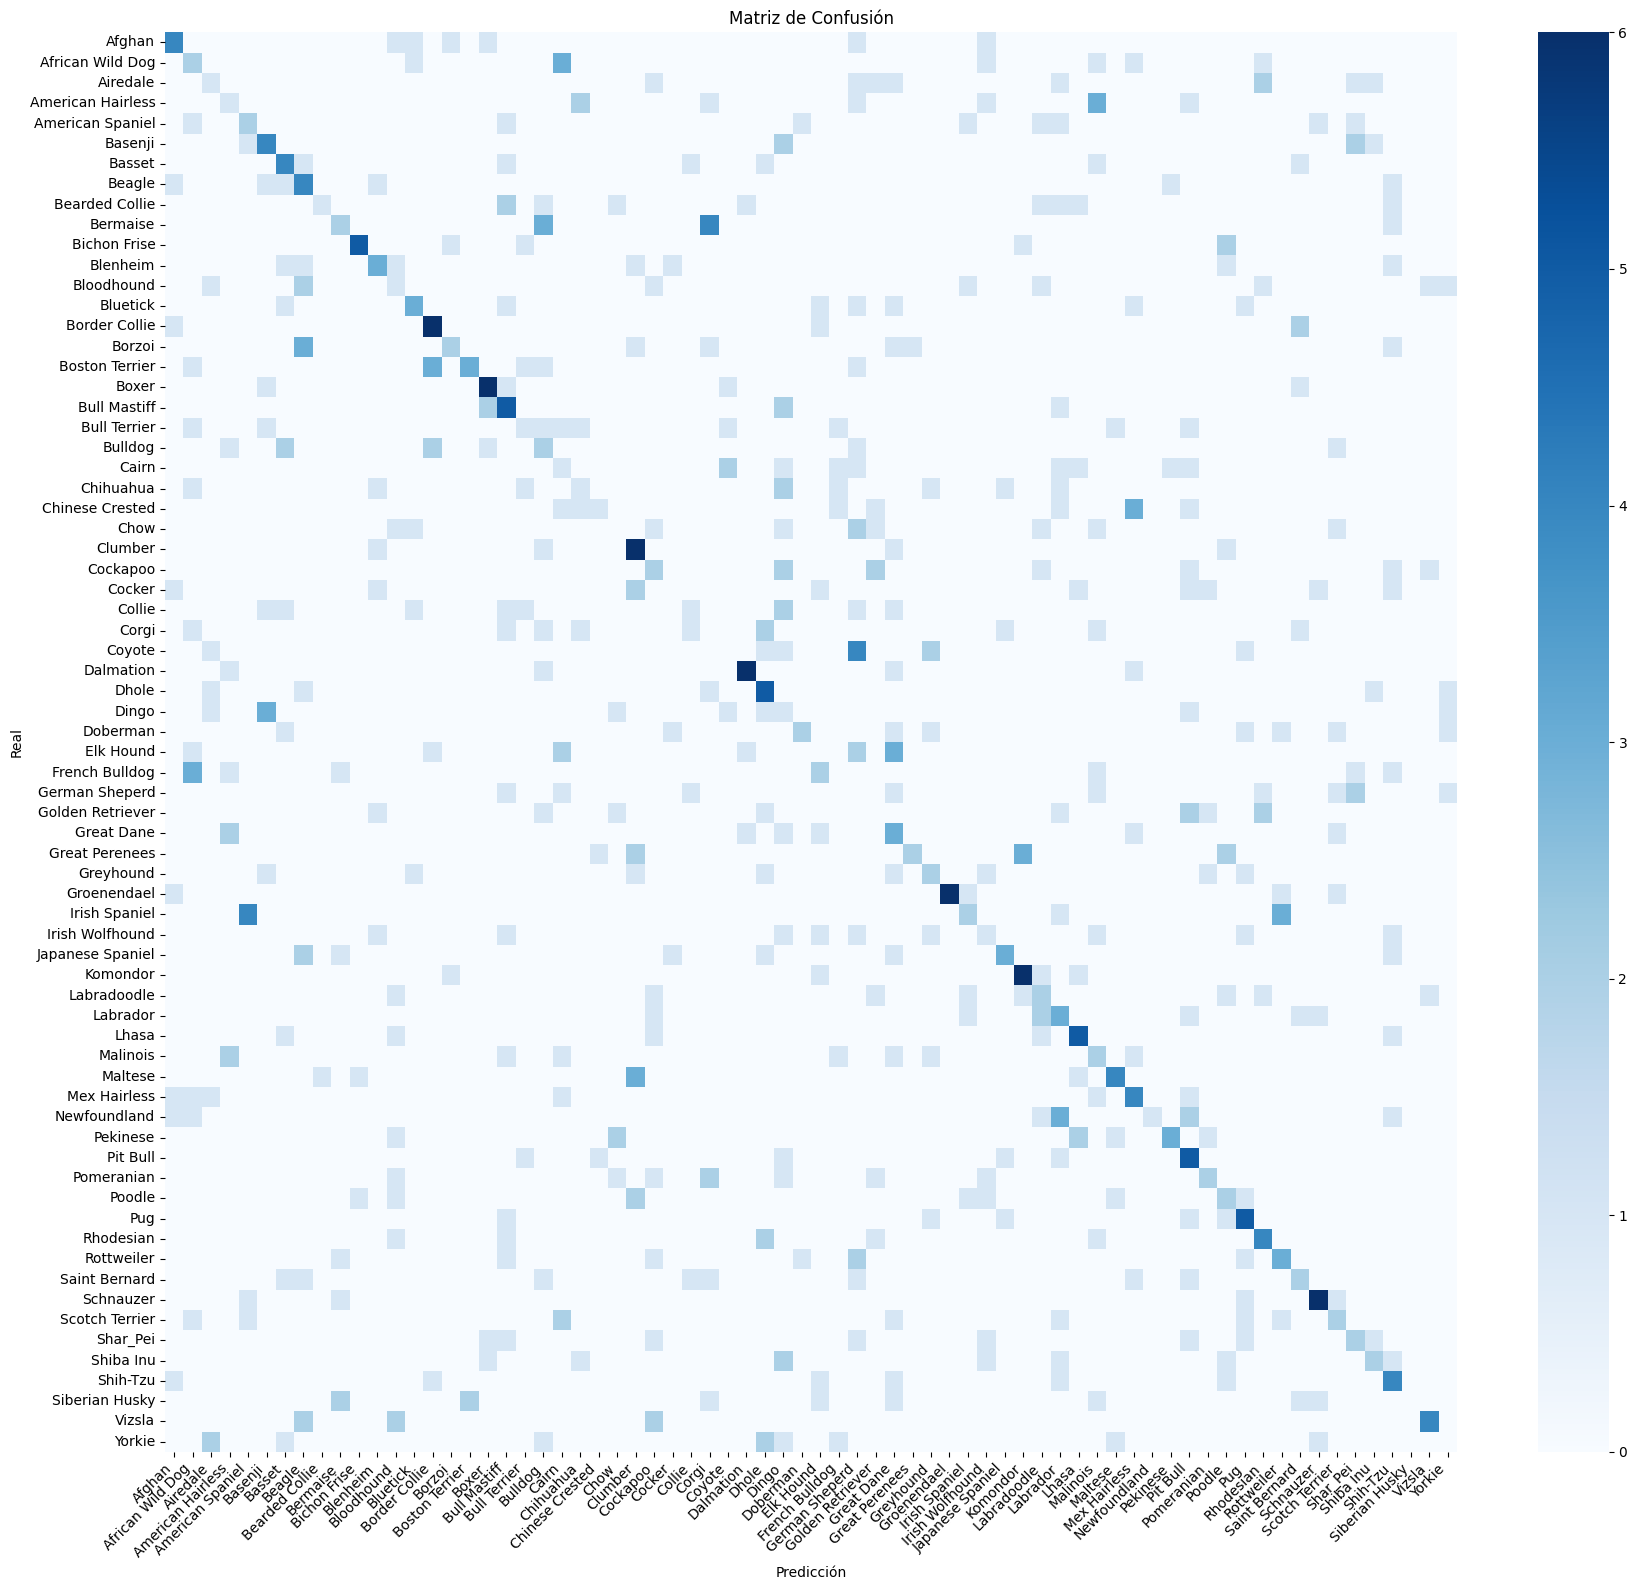

In [6]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            dummy_out = self.conv(dummy)
            self.flat_dim = dummy_out.view(1, -1).shape[1]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_dim, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model_custom = SimpleCNN(len(train_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model_custom.parameters(), lr=1e-4)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_custom = model_custom.to(device)

for epoch in range(10):
    model_custom.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_custom(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluación
model_custom.eval()
y_true_custom, y_pred_custom = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model_custom(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true_custom.extend(labels.numpy())
        y_pred_custom.extend(preds)

# Métricas
print(classification_report(y_true_custom, y_pred_custom, target_names=train_dataset.classes))

cm_custom = confusion_matrix(y_true_custom, y_pred_custom)
plt.figure(figsize=(18, 16))
sns.heatmap(
    cm_custom, 
    annot=False, 
    fmt='d', 
    cmap='Blues',
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes
)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### SimpleCNN (Red Convolucional Propia, 4 capas)
-----

**Principales hallazgos:**

- El modelo logra identificar correctamente algunas razas específicas, como **"Bichon Frise"**, **"Boxer"**, **"Groenendael"**, **"Komondor"** y **"Schnauzer"**, que presentan valores de *precisión*, *recall* y *f1-score* relativamente altos (algunos superiores a **0.50**).
- Sin embargo, la mayoría de las razas muestran valores bajos en todas las métricas, con varias clases donde el modelo no logra predecir correctamente ningún ejemplo (*f1-score* cercano a **0.00**), lo que indica dificultades para generalizar y distinguir entre razas visualmente similares o con pocos datos.
- El promedio *macro* y *ponderado* de las métricas es bajo (**alrededor de 0.25-0.29**), reflejando un rendimiento global limitado y un desbalance en la capacidad de clasificación entre las distintas clases.

**Síntesis:**  
El modelo SimpleCNN de 4 capas ***logra aprender algunas características útiles para ciertas razas***, pero en general su capacidad de discriminación es baja comparada con modelos preentrenados como **ResNet18**. Esto puede deberse a la menor profundidad, falta de regularización, o a la necesidad de mayor cantidad de datos y épocas de entrenamiento. Cosa que el modelo pre entrenado ResNet18 funciona mucho mejor con tan solo 1 época, contra las 10 del modelo propio y lograndolo en un cuarto del tiempo.